In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dropout, Dense, Activation, Conv1D, GlobalMaxPooling1D, MaxPooling1D, concatenate, Flatten
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from keras import Input
from keras.utils import np_utils

import datetime
import os

Using TensorFlow backend.


In [2]:
## 하이퍼 파라메터

delta = 1e-7
seq_len = 7
test_date = 180

level_1 = 15
level_2 = 35
level_3 = 75

num_level = 4

pm_target = level_3 * 2 # 매우나쁨의 두배
wind_speed_target = 14 # 강한 바람
wind_direction_target = 360 # 16방위

In [3]:
### 데이터 로드
data = pd.read_csv('dataset/PM_2.5_dataset.csv', index_col=0)
data.head()

pm_seoul_data = data['PM Seoul'].values
pm_beijing_data = data['PM Beijing'].values
wind_speed_seoul_data = data['avg wind speed seoul'].values
wind_direction_seoul_data = data['max wind direction seoul'].values
wind_speed_back_data = data['avg wind speed back'].values
wind_direction_back_data = data['max wind direction back'].values

In [4]:
## 시계열 함수
def make_sequential(data):
    for i in range(len(data)):
        if data[i] == 0:
            data[i] = data[i]+delta
        
    sequence_length = seq_len + 1
    
    temp_data = []
    for index in range((len(data) - sequence_length)+1):
        temp_data.append(data[index: index + sequence_length])
        
    return temp_data

In [5]:
def pm_norm_window(data):
    norm_data = []
    
    for i in range(len(data)):
        norm_data.append(data[i] / pm_target)
        
    return norm_data

In [6]:
def wind_speed_norm_window(data):
    norm_data = []
    
    for i in range(len(data)):
        norm_data.append(data[i] / wind_speed_target)
        
    return norm_data

In [7]:
def wind_direction_norm_window(data):
    norm_data = []
    
    for i in range(len(data)):
        norm_data.append(data[i] / wind_direction_target)
        
    return norm_data

In [44]:
def y_phased(data):
    for seq_data in data:
        temp = seq_data[-1]
        
        if temp < (level_1 / pm_target):
            seq_data[-1] = 0
            
        elif (level_1 / pm_target) <= temp < (level_2 / pm_target):
            seq_data[-1] = 1
            
        elif (level_2 / pm_target) <= temp < (level_3 / pm_target):
            seq_data[-1] = 2
            
        else:
            seq_data[-1] = 3
            
    return data         

In [45]:
norm_pm_seoul = np.array(y_phased(make_sequential(pm_norm_window(pm_seoul_data))))
norm_pm_beijing = np.array(y_phased(make_sequential(pm_norm_window(pm_beijing_data))))
norm_wind_speed_seoul = np.array(y_phased(make_sequential(wind_speed_norm_window(wind_speed_seoul_data))))
norm_wind_speed_back = np.array(y_phased(make_sequential(wind_speed_norm_window(wind_speed_back_data))))
norm_wind_direction_seoul = np.array(y_phased(make_sequential(wind_direction_norm_window(wind_direction_seoul_data))))
norm_wind_direction_back = np.array(y_phased(make_sequential(wind_direction_norm_window(wind_direction_back_data))))

In [46]:
## 병합함수

def marge_data(a, b, c, d, e, f):
    marged_data = []
    marge = []
    
    for a_index, b_index, c_index, d_index, e_index, f_index in zip(a, b, c, d, e, f):
        for i in range(len(a_index)):
            marge.append(a_index[i])
            marge.append(b_index[i])
            #marge.append(c_index[i])
            #marge.append(d_index[i])
            #marge.append(e_index[i])
            #marge.append(f_index[i])
            
        for i in range(1):
            marge.pop()
        
        marged_data.append(marge)
        marge = []
    
    return np.array(marged_data)

norm_result = marge_data(norm_pm_seoul, norm_pm_beijing, norm_wind_speed_seoul, 
                         norm_wind_speed_seoul, norm_wind_direction_seoul, norm_wind_direction_back)
print(norm_result[0])

[0.2915942  1.20722583 0.305      1.12520666 0.31222222 1.18373457
 0.26722222 1.13219136 0.39027778 0.9373251  0.64       0.9408642
 0.55416667 1.01493693 2.        ]


In [47]:
norm_result = norm_pm_seoul

In [ ]:
## 병합함수

def marge_data(a, b, c, d, e, f):
    marged_data = []
    marge = []
    
    for a_index, b_index, c_index, d_index, e_index, f_index in zip(a, b, c, d, e, f):
        for i in range(len(a_index)):
            marge.append(a_index[i])
            marge.append(b_index[i])
            #marge.append(c_index[i])
            #marge.append(d_index[i])
            #marge.append(e_index[i])
            #marge.append(f_index[i])
            
        for i in range(1):
            marge.pop()
        
        marged_data.append(marge)
        marge = []
    
    return np.array(marged_data)

norm_result = marge_data(norm_pm_seoul, norm_pm_beijing, norm_wind_speed_seoul, 
                         norm_wind_speed_seoul, norm_wind_direction_seoul, norm_wind_direction_back)
print(norm_result[0])

In [54]:
year = 365
train_cut = year * 8 + 1 -30

test_cut = -test_date
        
train = norm_result[:train_cut, :]
np.random.shuffle(train)

valid = norm_result[train_cut:test_cut, :]
#np.random.shuffle(valid)

test = norm_result[test_cut:, :]

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:,-1]
y_train = np.reshape(y_train, (y_train.shape[0], 1))
y_train = np_utils.to_categorical(y_train, num_level)

x_valid = valid[:, :-1]
x_valid = np.reshape(x_valid, (x_valid.shape[0], x_valid.shape[1], 1))
y_valid = valid[:,-1]
y_valid = np.reshape(y_valid, (y_valid.shape[0], 1))
y_valid = np_utils.to_categorical(y_valid, num_level)

x_test = test[:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = test[:,-1]
y_test = np.reshape(y_test, (y_test.shape[0], 1))
y_test = np_utils.to_categorical(y_test, num_level)

print(x_train.shape, x_valid.shape, x_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(2891, 7, 1) (574, 7, 1) (180, 7, 1)
(2891, 4) (574, 4) (180, 4)


In [ ]:
train_1 = norm_pm_seoul[:train_cut, :]
np.random.shuffle(train_1)
valid_1 = norm_pm_seoul[train_cut:test_cut, :]
test_1 = norm_pm_seoul[test_cut:, :]

x_train_1 = train_1[:, :-1]
x_train_1 = np.reshape(x_train_1, (x_train_1.shape[0], x_train_1.shape[1], 1))

x_valid_1 = valid_1[:, :-1]
x_valid_1 = np.reshape(x_valid_1, (x_valid_1.shape[0], x_valid_1.shape[1], 1))

x_test_1 = test_1[:, :-1]
x_test_1 = np.reshape(x_test_1, (x_test_1.shape[0], x_test_1.shape[1], 1))


train_2 = norm_pm_beijing[:train_cut, :]
np.random.shuffle(train_2)
valid_2 = norm_pm_beijing[train_cut:test_cut, :]
test_2 = norm_pm_beijing[test_cut:, :]

x_train_2 = train_2[:, :-1]
x_train_2 = np.reshape(x_train_2, (x_train_2.shape[0], x_train_2.shape[1], 1))

x_valid_2 = valid_2[:, :-1]
x_valid_2 = np.reshape(x_valid_2, (x_valid_2.shape[0], x_valid_2.shape[1], 1))

x_test_2 = test_2[:, :-1]
x_test_2 = np.reshape(x_test_2, (x_test_2.shape[0], x_test_2.shape[1], 1))

print(x_train_1.shape, x_valid_1.shape, x_test_1.shape)

In [ ]:
### 모델 체크포인터 롤백
MODEL_SAVE_FOLBER_PATH = './model/checkpoint_archi_5/'
if not os.path.exists(MODEL_SAVE_FOLBER_PATH):
    os.mkdir(MODEL_SAVE_FOLBER_PATH)
    
model_path = MODEL_SAVE_FOLBER_PATH + '{epoch:02d}-{val_loss:.4f}.hdf5'

# 체크포인트 생성 코드
cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss',verbose=1, save_best_only=True, mode='auto')

### 학습 모델 로드

model = load_model('model/pm_prediction_model_achi_6.h5')

In [76]:
### VCRNN 모델 설계
model = Sequential()


#model_vcr.add(Conv1D(32, 7, activation='linear',strides=1, input_shape=(30,1)))
#model_vcr.add(Conv1D(64, 7, activation='linear',strides=2, input_shape=(30,1)))
#model_vcr.add(Conv1D(128, 7, activation='relu',strides=3, input_shape=(30,1)))

#model_vcr.add(Conv1D(120, 2, activation='relu',strides=2))
# model.add(Conv1D(60, 3, activation='relu',strides=1, padding="same"))


model.add(LSTM(128, return_sequences=True, input_shape=(7,1)))

for i in range (2):
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5))

model.add(LSTM(64, return_sequences=False))

model.add(Dense(4, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 7, 128)            66560     
_________________________________________________________________
lstm_30 (LSTM)               (None, 7, 128)            131584    
_________________________________________________________________
dropout_15 (Dropout)         (None, 7, 128)            0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 7, 128)            131584    
_________________________________________________________________
dropout_16 (Dropout)         (None, 7, 128)            0         
_________________________________________________________________
lstm_32 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 260       
Total para

In [31]:


# 서울 미세먼지 lstm
pm_seoul_input = Input(shape=(30,1), dtype='float32', name='pm_seoul')
pm_seoul_lstm1 = LSTM(30, return_sequences=True)(pm_seoul_input)
#pm_seoul_lstm2 = LSTM(30, return_sequences=True)(pm_seoul_lstm1)
#pm_seoul_lstm3 = LSTM(30, return_sequences=True)(pm_seoul_lstm2)

# 중국 미세먼지 lstm
pm_beijing_input = Input(shape=(30,1),dtype='float32', name='pm_beijing')
pm_beijing_lstm1 = LSTM(30, return_sequences=True)(pm_beijing_input)
#pm_beijing_lstm2 = LSTM(30, return_sequences=True)(pm_beijing_lstm1)
#pm_beijing_lstm3 = LSTM(30, return_sequences=True)(pm_beijing_lstm2)

concatenated = concatenate([pm_seoul_lstm1, pm_beijing_lstm1])



conv_layer1 = Conv1D(10, 3, activation='linear', strides=3)(concatenated)


flatten = Flatten()(conv_layer1)



output_layer = Dense(1, activation='linear')(flatten)

model = Model([pm_seoul_input, pm_beijing_input], output_layer)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pm_seoul (InputLayer)           (None, 30, 1)        0                                            
__________________________________________________________________________________________________
pm_beijing (InputLayer)         (None, 30, 1)        0                                            
__________________________________________________________________________________________________
lstm_37 (LSTM)                  (None, 30, 30)       3840        pm_seoul[0][0]                   
__________________________________________________________________________________________________
lstm_38 (LSTM)                  (None, 30, 30)       3840        pm_beijing[0][0]                 
__________________________________________________________________________________________________
concatenat

In [ ]:
## 콜백 리스트 - 정해진 에폭동안 모니터링 지표가 향상되지 않으면 훈련을 중지
callback_list = [
    keras.callbacks.EarlyStooping(
        monitor='val_acc', patience=1,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='model/checkpoint/temp_model.h5',
        moitor='val_loss',
        save_best_only=True,
    )
]

In [13]:
## 검증손실이 향상되지 않을때 학습율을 작게함
callback_list = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1, # 콜백 호출시 학습률을 10배로 줄인다.
    patience=5,
    )
]

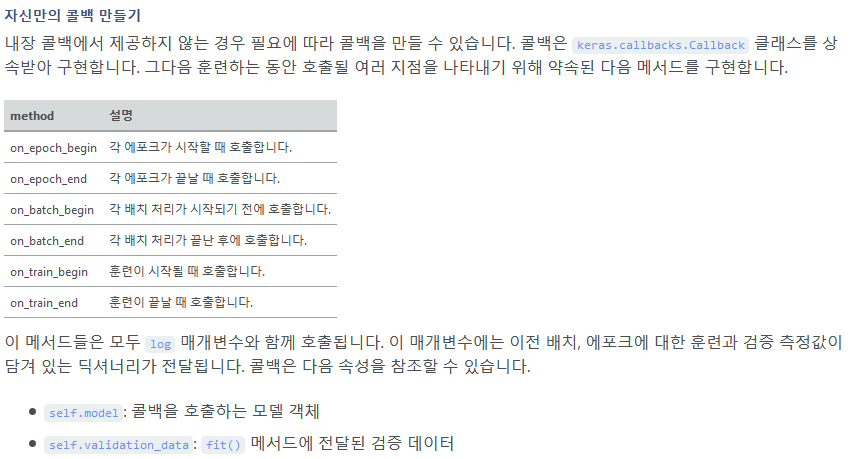

In [62]:
### 모델 학습
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.compile(loss='categorical_crossentropy', optimizer='Nadam')

hist = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=15, batch_size=100, callbacks=callback_list)
#hist = model.fit({'pm_seoul':x_train_1, 'pm_beijing':x_train_2}, y_train, validation_data=({'pm_seoul':x_valid_1, 'pm_beijing':x_valid_2}, y_valid), epochs=10, batch_size=100)

Train on 2891 samples, validate on 574 samples
Epoch 1/15
2891/2891 [==============================] - 6s 2ms/step - loss: 0.8380 - val_loss: 0.8565
Epoch 2/15
2891/2891 [==============================] - 2s 591us/step - loss: 0.8444 - val_loss: 0.8435
Epoch 3/15
2891/2891 [==============================] - 2s 679us/step - loss: 0.8447 - val_loss: 0.8614
Epoch 4/15
2891/2891 [==============================] - 2s 608us/step - loss: 0.8432 - val_loss: 0.8415
Epoch 5/15
2891/2891 [==============================] - 2s 608us/step - loss: 0.8429 - val_loss: 0.8504
Epoch 6/15
2891/2891 [==============================] - 2s 600us/step - loss: 0.8369 - val_loss: 0.8390
Epoch 7/15
2891/2891 [==============================] - 2s 607us/step - loss: 0.8377 - val_loss: 0.8576
Epoch 8/15
2891/2891 [==============================] - 2s 596us/step - loss: 0.8395 - val_loss: 0.8626
Epoch 9/15
2891/2891 [==============================] - 2s 611us/step - loss: 0.8349 - val_loss: 0.8432
Epoch 10/15
2891/28

In [12]:
## 모델 저장
model.save('model/pm_prediction_model_achi_new.h5')

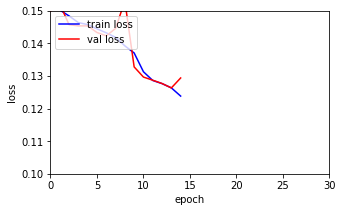

In [60]:
## 손실함수 변화 측정
fig = plt.figure(facecolor='white', figsize=(5, 3))
loss_ax = fig.add_subplot(111)

loss_ax.plot(hist.history['loss'], 'b', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.1, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')

plt.xlim([0, 30])
plt.ylim([0.1, 0.15])

plt.show()

In [24]:
## 결과 실제화
y_true = pm_seoul_data[test_cut:]

pred = model.predict(x_test)

y_pred = pred * pm_target

In [71]:
pred = model.predict(x_test)

y_pred

array([[[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]],

       [[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]],

       [[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]],

       ...,

       [[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]],

       [[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]],

       [[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]]], dtype=float32)

In [67]:
pred = model.predict(x_test)
y_pred = np_utils.to_categorical(pred, num_level)

correct = 0
for i in range(len(pred)):

    if pred[i] == y_test[i]:
        correct += 1
    else:
        continue
        
acc = correct / len(pred)
        
print("acc: ", acc)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

D:\_setup\anaconda3\envs\py3.7\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


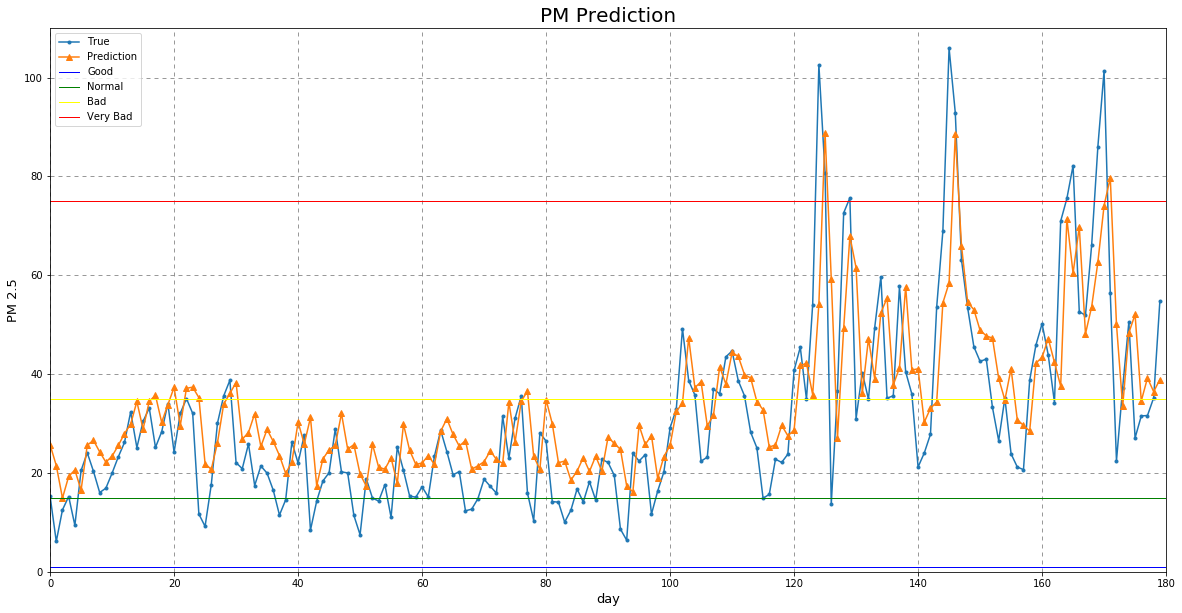

In [25]:
fig = plt.figure(facecolor='white', figsize=(20, 10))

plt.title('PM Prediction', fontsize=20)

ax = fig.add_subplot(111)
ax.plot(y_true, label='True', marker='.')
ax.plot(y_pred, label='Prediction', marker='^')

plt.grid(color='gray', dashes=(5,5))

plt.axhline(y=1, color='blue', linewidth=1, label='Good')
plt.axhline(y=level_1, color='green', linewidth=1, label='Normal')
plt.axhline(y=level_2, color='yellow', linewidth=1, label='Bad')
plt.axhline(y=level_3, color='red', linewidth=1, label='Very Bad')

plt.xlabel('day', fontsize=13)
plt.ylabel('PM 2.5', fontsize=13)

plt.xlim([0, test_date])
plt.ylim([0, 110])

ax.legend()
plt.show()

In [26]:
## 단계별 정확도 및 총 정확도 계산 함수
def pm_level(pm):
    
    level_temp = []
    
    for i in range(len(pm)):
        if pm[i] <= level_1:
            level_temp.append(1)
        elif pm[i] <= level_2:
            level_temp.append(2)
        elif pm[i] <= level_3:
            level_temp.append(3)
        else:
            level_temp.append(4)
            
    return level_temp
    

In [27]:
def error_check(true, pred):
    y_true_lv = pm_level(true)
    y_pred_lv = pm_level(pred)
    
    level_1_acc = 0
    level_2_acc = 0
    level_3_acc = 0
    level_4_acc = 0

    level_1_count = y_true_lv.count(1)
    level_2_count = y_true_lv.count(2)
    level_3_count = y_true_lv.count(3)
    level_4_count = y_true_lv.count(4)
            
    
    error_rate_temp = []
    
    for i in range(len(y_pred_lv)):
        if y_pred_lv[i] == y_true_lv[i]:
            error_rate_temp.append(1)
            
            if y_pred_lv[i] == 1:
                level_1_acc += 1
            elif y_pred_lv[i] == 2:
                level_2_acc += 1
            elif y_pred_lv[i] == 3:
                level_3_acc += 1
            else:
                level_4_acc += 1
                    
        else:
            error_rate_temp.append(0)
    
    total_acc = sum(error_rate_temp) / len(error_rate_temp)
    
    
    level_1_accuracy = float(level_1_acc / level_1_count)
    level_2_accuracy = float(level_2_acc / level_2_count)
    level_3_accuracy = float(level_3_acc / level_3_count)
    level_4_accuracy = float(level_4_acc / level_4_count)
    
    level_accuracy = [level_1_accuracy,level_2_accuracy, level_3_accuracy, level_4_accuracy]
    
    return total_acc, level_accuracy


In [28]:
## 정확도 결과
total_acc, level_acc = error_check(y_true, y_pred)
print("total accuracy:", total_acc)
print("level 'Good' accuracy:", level_acc[0])
print("level 'Normal' accuracy:", level_acc[1])
print("level 'Bad' accuracy:", level_acc[2])
print("level 'Veray Bad' accuracy:", level_acc[3])

total accuracy: 0.6444444444444445
level 'Good' accuracy: 0.034482758620689655
level 'Normal' accuracy: 0.8105263157894737
level 'Bad' accuracy: 0.7659574468085106
level 'Veray Bad' accuracy: 0.2222222222222222
